# Music Recommendation System - Training and Evaluation Analysis
# =====================================================================

In [1]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from IPython.display import display, Markdown

# Set plot style and figure size defaults
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
sns.set_context("notebook", font_scale=1.2)

# Define custom colors
colors = {
    'train': '#1f77b4',  # blue
    'val': '#ff7f0e',    # orange
    'test': '#2ca02c',   # green
    'precision': '#d62728',  # red
    'recall': '#9467bd',  # purple
    'f1': '#8c564b',      # brown
    'auc': '#e377c2',     # pink
    'accuracy': '#7f7f7f',  # gray
    'loss': '#bcbd22',     # olive
    'ndcg': '#17becf',    # cyan
    'map': '#ff9896',     # light red
    'background': '#f5f5f5'  # light gray
}

# Cell 2: Load and inspect the data

In [2]:
history_path = "../logs/training_history.csv"
test_results_path = "../logs/test_results.csv"

In [3]:

# Load training history data
train_history = pd.read_csv(history_path)

# Load test results data
test_results = pd.read_csv(test_results_path)

# Display basic information about the datasets
print("Training History Overview:")
display(train_history.head(3))
print(f"Number of epochs: {len(train_history)}")
print("\nTest Results:")
display(test_results)

Training History Overview:


,epoch,train_accuracy,train_precision,train_recall,train_f1,train_auc,train_tn,train_fp,train_fn,train_tp,...,val_fp,val_fn,val_tp,val_ndcg@5,val_ndcg@10,val_ndcg@20,val_map@5,val_map@10,val_map@20,val_loss
0,1,0.891857,0.097744,0.02,0.033206,0.521801,6230,120,637,13,...,0,93,0,0.095106,0.095106,0.095106,0.093865,0.093865,0.093865,0.308999
1,2,0.907143,0.000000,0.00,0.000000,0.538880,6350,0,650,0,...,0,93,0,0.095106,0.095106,0.095106,0.093865,0.093865,0.093865,0.304325
2,3,0.907143,0.000000,0.00,0.000000,0.582814,6350,0,650,0,...,0,93,0,0.095251,0.095251,0.095251,0.094050,0.094050,0.094050,0.309011


Number of epochs: 12

Test Results:


,accuracy,precision,recall,f1,auc,tn,fp,fn,tp,ndcg@5,ndcg@10,ndcg@20,map@5,map@10,map@20,loss
0,0.907,0.0,0.0,0.0,0.617044,1814,0,186,0,0.106941,0.106941,0.106941,0.10479,0.10479,0.10479,0.308891


In [4]:
# Cell 3: Basic statistics and data integrity check
# Calculate summary statistics for training history
train_stats = train_history.describe()

# Check for missing values
missing_train = train_history.isnull().sum()
missing_test = test_results.isnull().sum()

print("Summary Statistics for Training History:")
display(train_stats)

print("\nMissing values in Training History:")
display(missing_train[missing_train > 0] if any(missing_train > 0) else "No missing values")

print("\nMissing values in Test Results:")
display(missing_test[missing_test > 0] if any(missing_test > 0) else "No missing values")

# Check for irregular patterns in metrics
print("\nChecking for unusual metric patterns:")
unusual_metrics = []

# Check if any accuracy values are outside expected range [0, 1]
if any(train_history['train_accuracy'] > 1) or any(train_history['train_accuracy'] < 0):
    unusual_metrics.append("Train accuracy outside [0, 1]")
if any(train_history['val_accuracy'] > 1) or any(train_history['val_accuracy'] < 0):
    unusual_metrics.append("Validation accuracy outside [0, 1]")

# Check for precision/recall/f1 issues
if all(train_history['train_precision'] == 0) and all(train_history['train_recall'] == 0):
    unusual_metrics.append("All train precision and recall values are 0")
if all(train_history['val_precision'] == 0) and all(train_history['val_recall'] == 0):
    unusual_metrics.append("All validation precision and recall values are 0")

if unusual_metrics:
    print("Found unusual patterns:")
    for issue in unusual_metrics:
        print(f"- {issue}")
else:
    print("No obvious metric irregularities found.")

Summary Statistics for Training History:


,epoch,train_accuracy,train_precision,train_recall,train_f1,train_auc,train_tn,train_fp,train_fn,train_tp,...,val_fp,val_fn,val_tp,val_ndcg@5,val_ndcg@10,val_ndcg@20,val_map@5,val_map@10,val_map@20,val_loss
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,...,12.0,12.0,12.0,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,6.500000,0.905869,0.049812,0.001795,0.003023,0.649727,6339.916667,10.083333,648.833333,1.166667,...,0.0,93.0,0.0,0.095273,0.095273,0.095273,0.094081,0.094081,0.094081,0.309378
std,3.605551,0.004413,0.144530,0.005750,0.009546,0.073047,34.615967,34.615967,3.737606,3.737606,...,0.0,0.0,0.0,0.000226,0.000226,0.000226,0.000303,0.000303,0.000303,0.002697
min,1.000000,0.891857,0.000000,0.000000,0.000000,0.521801,6230.000000,0.000000,637.000000,0.000000,...,0.0,93.0,0.0,0.094842,0.094842,0.094842,0.093496,0.093496,0.093496,0.304325
25%,3.750000,0.907143,0.000000,0.000000,0.000000,0.600066,6350.000000,0.000000,650.000000,0.000000,...,0.0,93.0,0.0,0.095215,0.095215,0.095215,0.094004,0.094004,0.094004,0.308027
50%,6.500000,0.907143,0.000000,0.000000,0.000000,0.659911,6350.000000,0.000000,650.000000,0.000000,...,0.0,93.0,0.0,0.095251,0.095251,0.095251,0.094050,0.094050,0.094050,0.309182
75%,9.250000,0.907143,0.000000,0.000000,0.000000,0.719321,6350.000000,0.000000,650.000000,0.000000,...,0.0,93.0,0.0,0.095287,0.095287,0.095287,0.094096,0.094096,0.094096,0.311949
max,12.000000,0.907143,0.500000,0.020000,0.033206,0.734904,6350.000000,120.000000,650.000000,13.000000,...,0.0,93.0,0.0,0.095660,0.095660,0.095660,0.094605,0.094605,0.094605,0.313307



Missing values in Training History:


'No missing values'


Missing values in Test Results:


'No missing values'


Checking for unusual metric patterns:
Found unusual patterns:
- All validation precision and recall values are 0


In [5]:
# Cell 4: Overview of Model Results
def display_model_summary():
    """Present a high-level summary of the model's performance"""
    # Get final epoch metrics
    final_epoch = train_history.iloc[-1]
    
    # Create markdown table for summary
    markdown_text = """
    ## Music Recommendation System Performance Summary
    
    ### Training Results (Final Epoch)
    | Metric | Training | Validation |
    |--------|----------|------------|
    | Accuracy | {:.4f} | {:.4f} |
    | AUC | {:.4f} | {:.4f} |
    | Loss | {:.4f} | {:.4f} |
    | NDCG@5 | N/A | {:.4f} |
    | MAP@5 | N/A | {:.4f} |
    
    ### Test Results
    | Metric | Value |
    |--------|-------|
    | Accuracy | {:.4f} |
    | AUC | {:.4f} |
    | Loss | {:.4f} |
    | NDCG@5 | {:.4f} |
    | MAP@5 | {:.4f} |
    
    """.format(
        final_epoch['train_accuracy'], final_epoch['val_accuracy'],
        final_epoch['train_auc'], final_epoch['val_auc'],
        final_epoch['train_loss'], final_epoch['val_loss'],
        final_epoch['val_ndcg@5'],
        final_epoch['val_map@5'],
        
        test_results['accuracy'].iloc[0],
        test_results['auc'].iloc[0],
        test_results['loss'].iloc[0],
        test_results['ndcg@5'].iloc[0],
        test_results['map@5'].iloc[0]
    )
    
    display(Markdown(markdown_text))
    
    # Interpretation
    interpretations = []
    
    # Compare final training and validation performance
    train_val_acc_diff = abs(final_epoch['train_accuracy'] - final_epoch['val_accuracy'])
    if train_val_acc_diff > 0.05:
        interpretations.append(f"- **Potential Overfitting**: The difference between training and validation accuracy is {train_val_acc_diff:.4f}, which may indicate overfitting.")
    else:
        interpretations.append(f"- **Good Generalization**: The model shows similar performance on training and validation sets (accuracy difference: {train_val_acc_diff:.4f}).")
    
    # Evaluate recommendation quality
    if final_epoch['val_ndcg@5'] < 0.2:
        interpretations.append(f"- **Low Recommendation Quality**: NDCG@5 value of {final_epoch['val_ndcg@5']:.4f} indicates that the recommendation rankings need improvement.")
    elif final_epoch['val_ndcg@5'] < 0.4:
        interpretations.append(f"- **Moderate Recommendation Quality**: NDCG@5 value of {final_epoch['val_ndcg@5']:.4f} shows room for improvement in recommendation rankings.")
    else:
        interpretations.append(f"- **Good Recommendation Quality**: NDCG@5 value of {final_epoch['val_ndcg@5']:.4f} indicates effective recommendation rankings.")
    
    # Check if precision/recall issues
    if test_results['precision'].iloc[0] == 0 or test_results['recall'].iloc[0] == 0:
        interpretations.append("- **Class Imbalance Issue**: Zero precision or recall suggests a potential class imbalance problem or model bias.")
    
    # Display interpretations
    display(Markdown("### Key Observations"))
    for interp in interpretations:
        display(Markdown(interp))

# Execute the summary function
display_model_summary()


    ## Music Recommendation System Performance Summary
    
    ### Training Results (Final Epoch)
    | Metric | Training | Validation |
    |--------|----------|------------|
    | Accuracy | 0.9071 | 0.9070 |
    | AUC | 0.7235 | 0.6092 |
    | Loss | 0.2809 | 0.3120 |
    | NDCG@5 | N/A | 0.0957 |
    | MAP@5 | N/A | 0.0946 |
    
    ### Test Results
    | Metric | Value |
    |--------|-------|
    | Accuracy | 0.9070 |
    | AUC | 0.6170 |
    | Loss | 0.3089 |
    | NDCG@5 | 0.1069 |
    | MAP@5 | 0.1048 |
    
    

### Key Observations

- **Good Generalization**: The model shows similar performance on training and validation sets (accuracy difference: 0.0001).

- **Low Recommendation Quality**: NDCG@5 value of 0.0957 indicates that the recommendation rankings need improvement.

- **Class Imbalance Issue**: Zero precision or recall suggests a potential class imbalance problem or model bias.

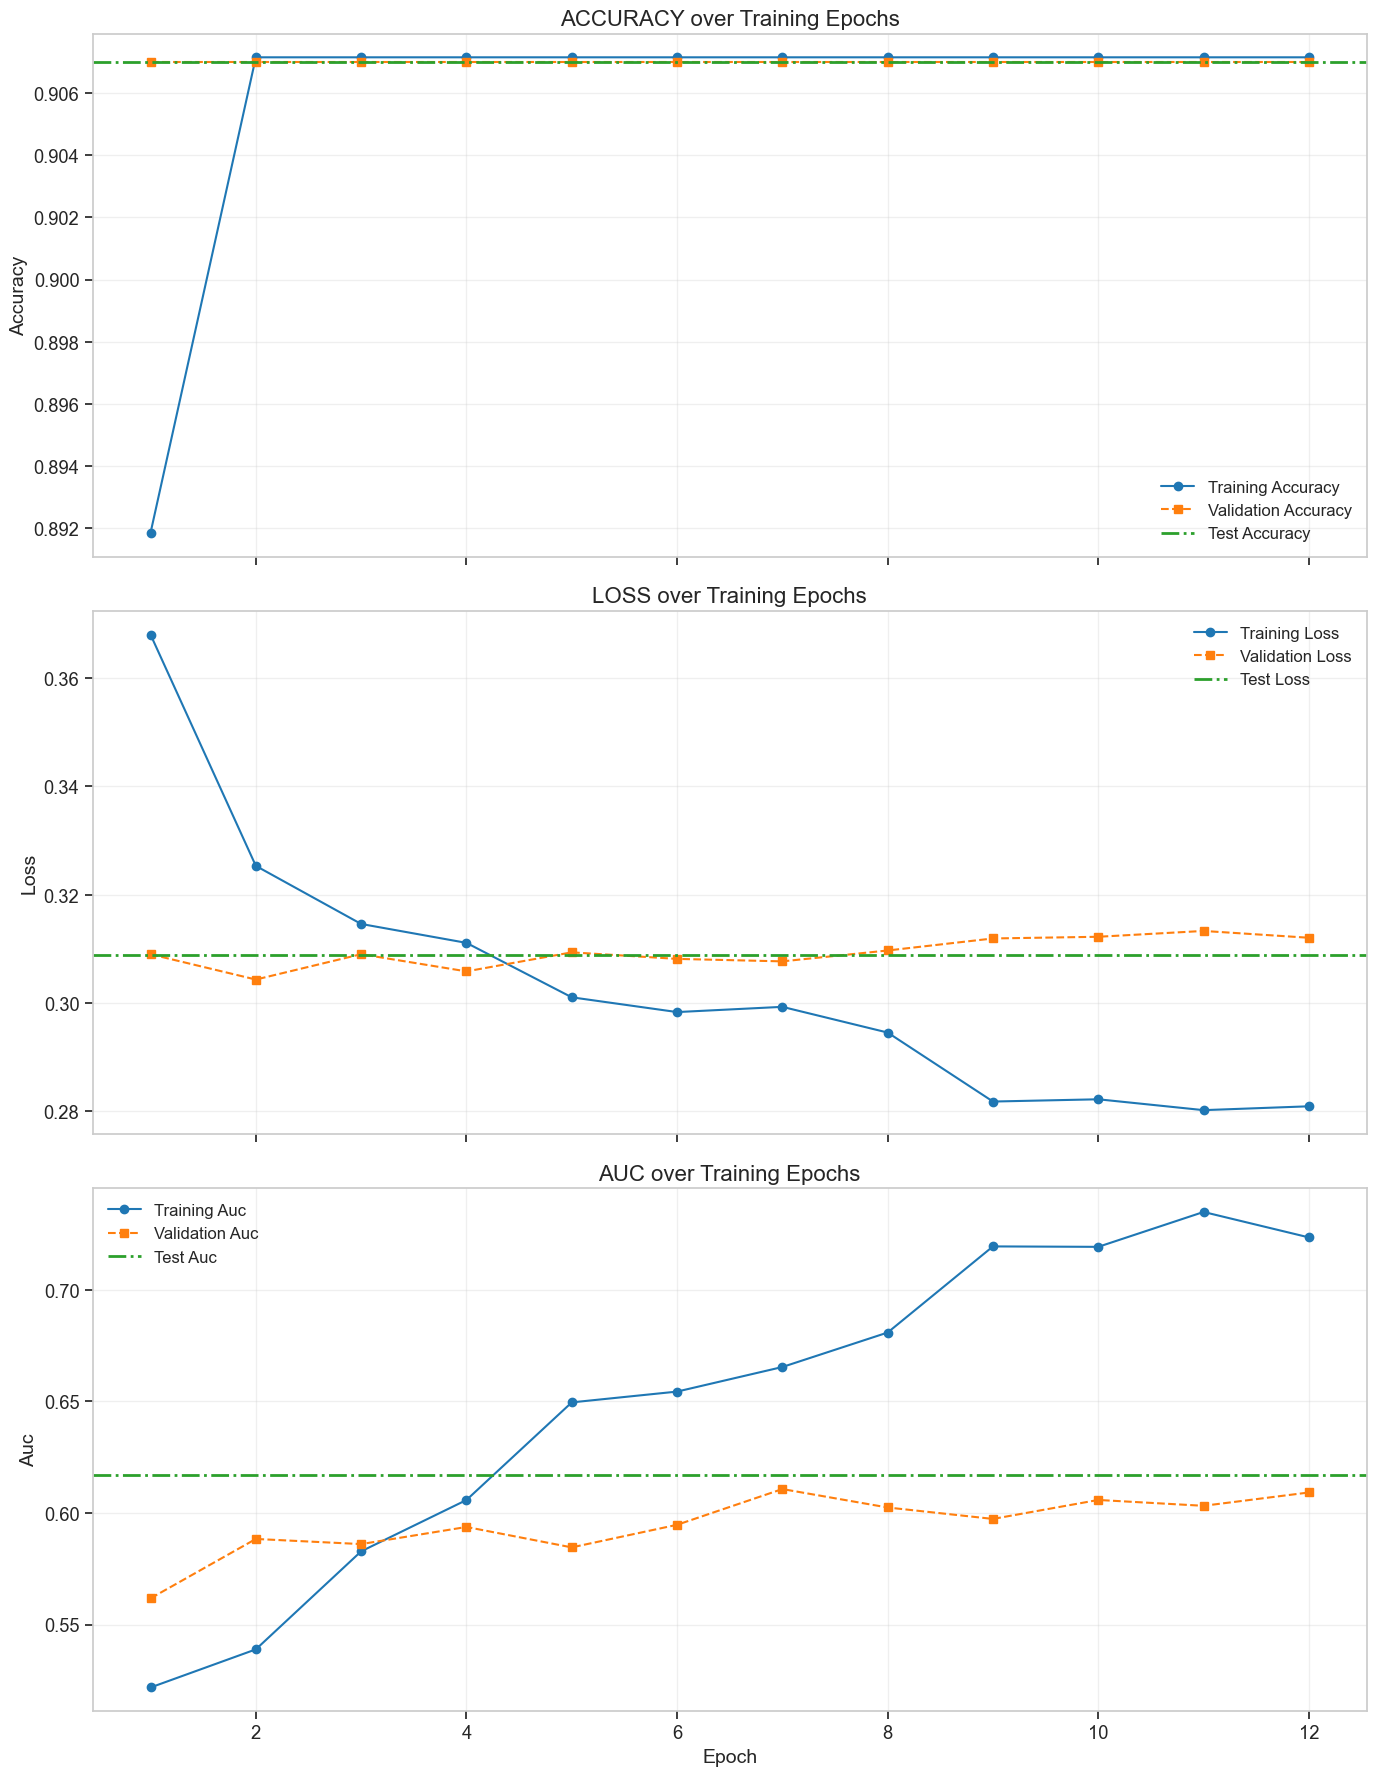

In [6]:
# Cell 5: Training and Validation Metrics Visualization
def plot_training_history(metrics=['accuracy', 'loss', 'auc']):
    """
    Plot the specified metrics over epochs for both training and validation sets
    
    Parameters:
    metrics (list): List of metrics to plot (default: accuracy, loss, auc)
    """
    num_metrics = len(metrics)
    fig, axes = plt.subplots(num_metrics, 1, figsize=(14, 6*num_metrics), sharex=True)
    if num_metrics == 1:
        axes = [axes]  # Make axes indexable for single metric case
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        # Get column names for the metric (training and validation)
        train_col = f'train_{metric}'
        val_col = f'val_{metric}'
        
        # Plot the metrics
        ax.plot(train_history['epoch'], train_history[train_col], 
                color=colors['train'], marker='o', linestyle='-', markersize=6, 
                label=f'Training {metric.capitalize()}')
        
        ax.plot(train_history['epoch'], train_history[val_col], 
                color=colors['val'], marker='s', linestyle='--', markersize=6, 
                label=f'Validation {metric.capitalize()}')
        
        # Add horizontal line for test result
        if metric in test_results.columns:
            ax.axhline(y=test_results[metric].iloc[0], color=colors['test'], 
                      linestyle='-.', linewidth=2, label=f'Test {metric.capitalize()}')
        
        # Set plot title and labels
        ax.set_title(f'{metric.upper()} over Training Epochs', fontsize=16)
        ax.set_ylabel(metric.capitalize(), fontsize=14)
        ax.legend(loc='best', fontsize=12)
        ax.grid(True, alpha=0.3)
        
        # Set x-axis ticks to be integers
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Set common x-axis label for the bottom plot
    axes[-1].set_xlabel('Epoch', fontsize=14)
    
    plt.tight_layout()
    plt.show()

# Plot common metrics
plot_training_history(['accuracy', 'loss', 'auc'])

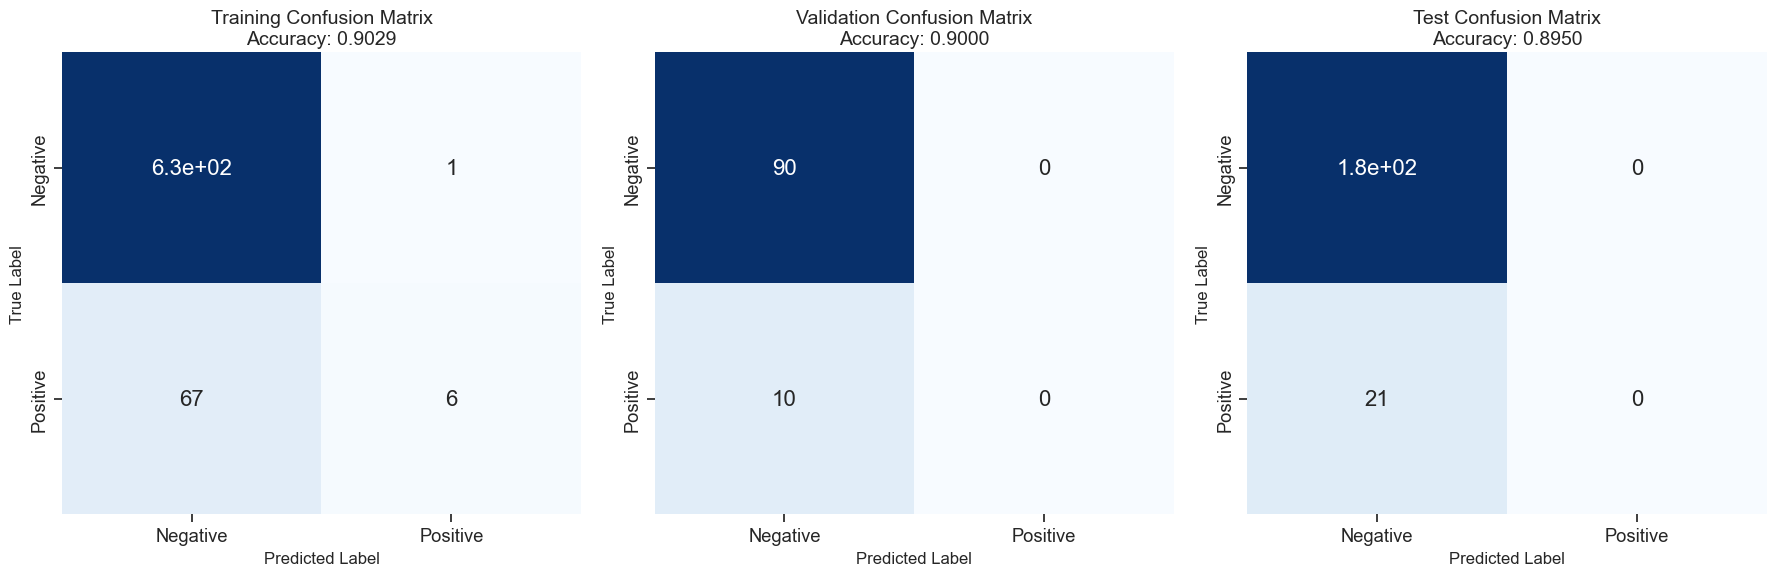

In [7]:
# Cell 6: Visualization of Confusion Matrix and Classification Metrics
def plot_confusion_matrices():
    """Plot confusion matrices for final training, validation, and test sets"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Get confusion matrix values
    final_epoch = train_history.iloc[-1]
    
    # Training confusion matrix
    cm_train = np.array([[final_epoch['train_tn'], final_epoch['train_fp']],
                          [final_epoch['train_fn'], final_epoch['train_tp']]])
    
    # Validation confusion matrix
    cm_val = np.array([[final_epoch['val_tn'], final_epoch['val_fp']],
                        [final_epoch['val_fn'], final_epoch['val_tp']]])
    
    # Test confusion matrix
    cm_test = np.array([[test_results['tn'].iloc[0], test_results['fp'].iloc[0]],
                         [test_results['fn'].iloc[0], test_results['tp'].iloc[0]]])
    
    titles = ['Training Confusion Matrix', 'Validation Confusion Matrix', 'Test Confusion Matrix']
    cms = [cm_train, cm_val, cm_test]
    
    for i, (title, cm) in enumerate(zip(titles, cms)):
        ax = axes[i]
        
        # Calculate metrics explicitly from confusion matrix for validation
        tn, fp, fn, tp = cm.ravel()
        total = tn + fp + fn + tp
        if total > 0:
            accuracy = (tn + tp) / total
        else:
            accuracy = 0
            
        # Create heatmap
        sns.heatmap(cm, annot=True, cmap="Blues", ax=ax,
                    cbar=False, annot_kws={"size": 16})
        
        ax.set_title(f"{title}\nAccuracy: {accuracy:.4f}", fontsize=14)
        ax.set_xlabel('Predicted Label', fontsize=12)
        ax.set_ylabel('True Label', fontsize=12)
        ax.set_xticklabels(['Negative', 'Positive'])
        ax.set_yticklabels(['Negative', 'Positive'])
    
    plt.tight_layout()
    plt.show()

# Execute the confusion matrix visualization
plot_confusion_matrices()

In [8]:
print("val_ndcg@20".split("_")[1])

ndcg@20


NDCG Columns: ['val_ndcg@5', 'val_ndcg@10', 'val_ndcg@20']
MAP Columns: ['val_map@5', 'val_map@10', 'val_map@20']
Cutoffs: [5, 10, 20]
Final NDCG Values: [0.0956602866091227, 0.0956602866091227, 0.0956602866091227]
Final MAP Values: [0.0946045824094604, 0.0946045824094604, 0.0946045824094604]
Test NDCG Values: [0.1069406402803402, 0.1069406402803402, 0.1069406402803402]
Test MAP Values: [0.1047903563941299, 0.1047903563941299, 0.1047903563941299]


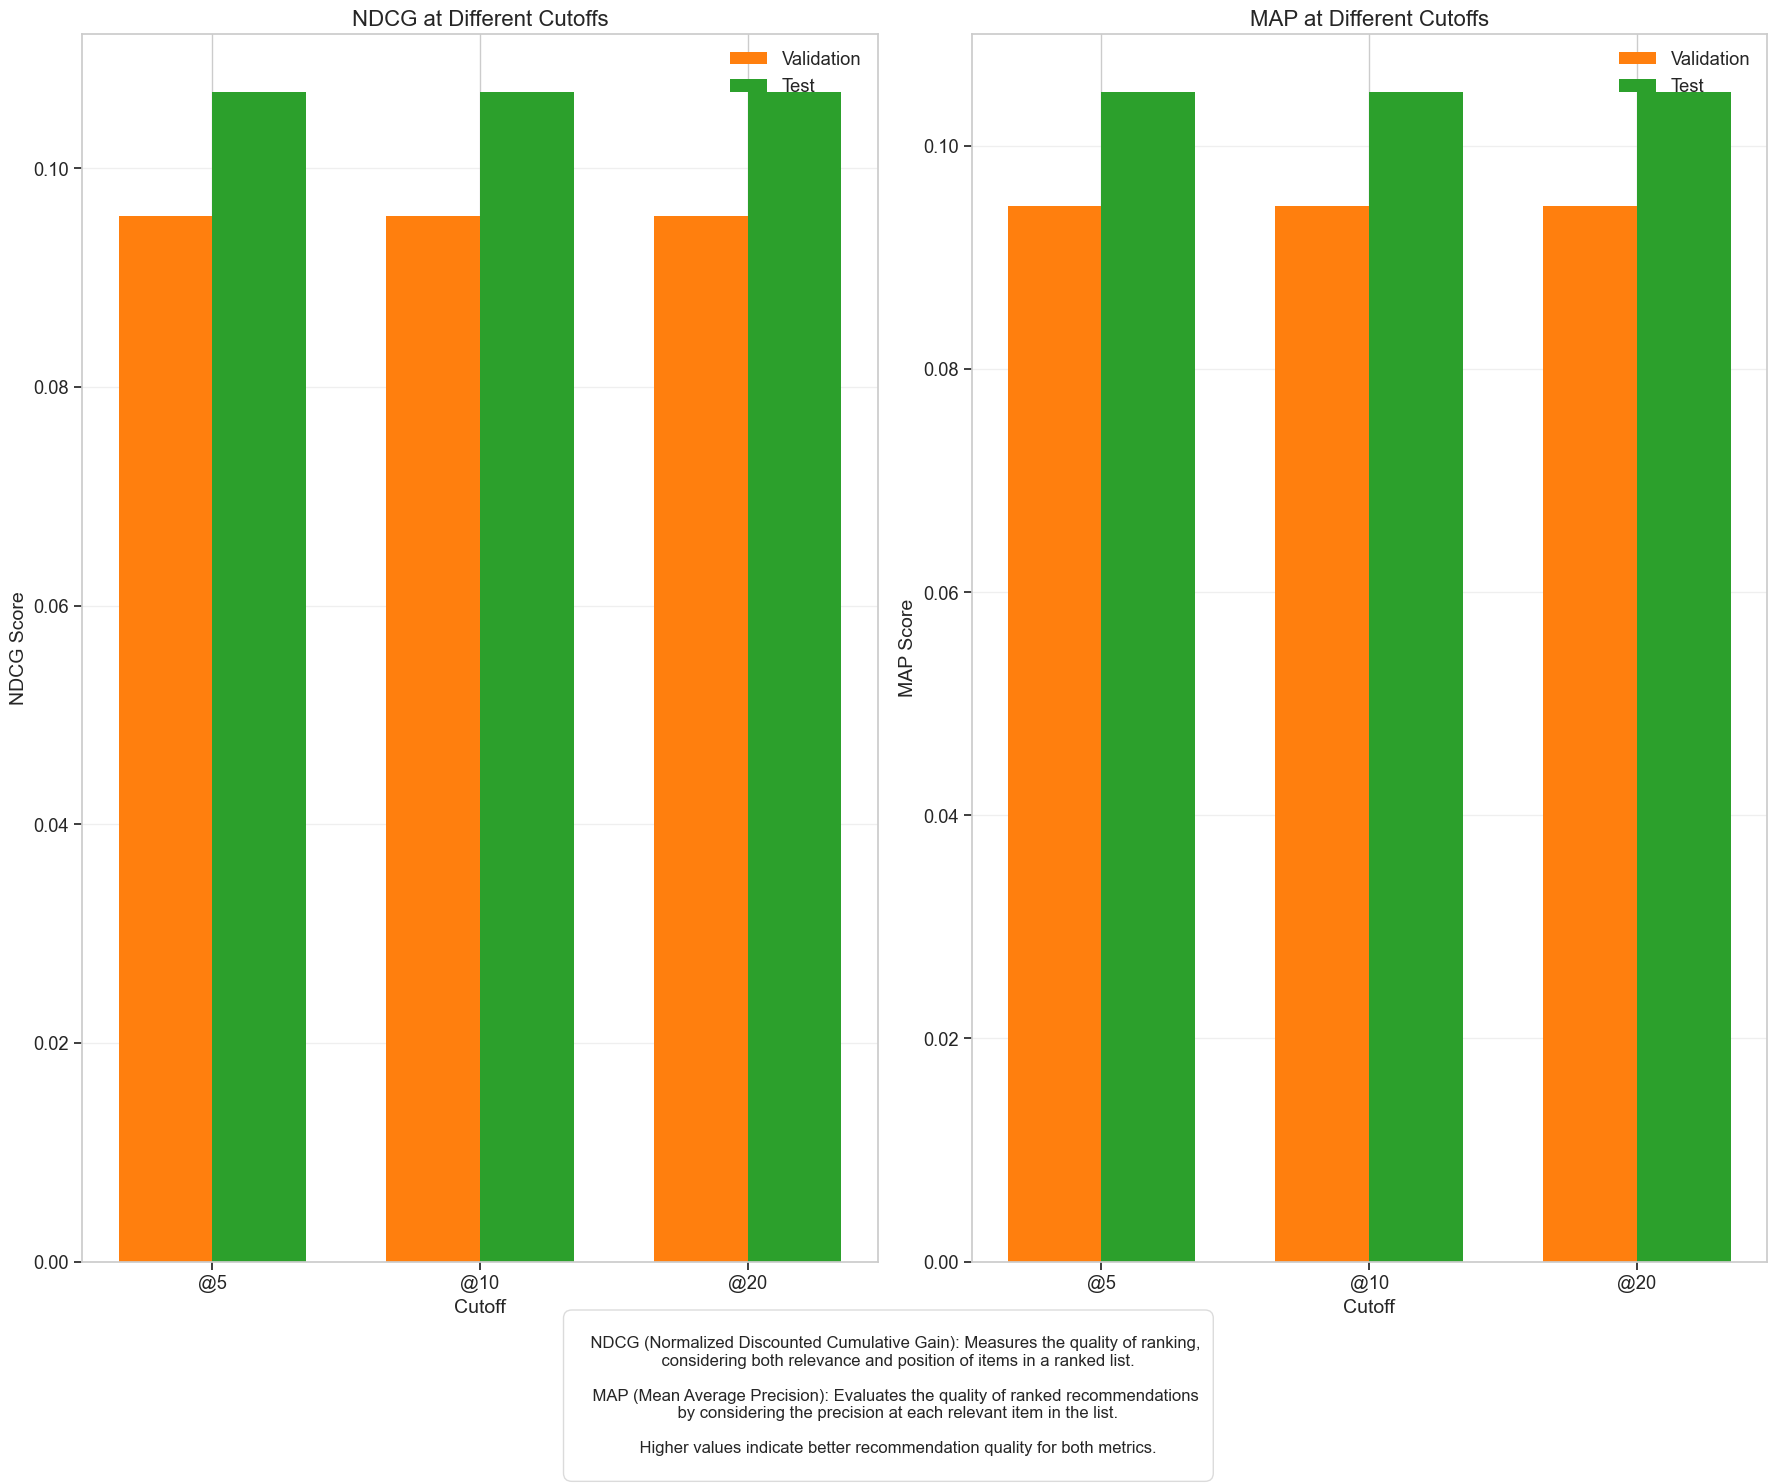

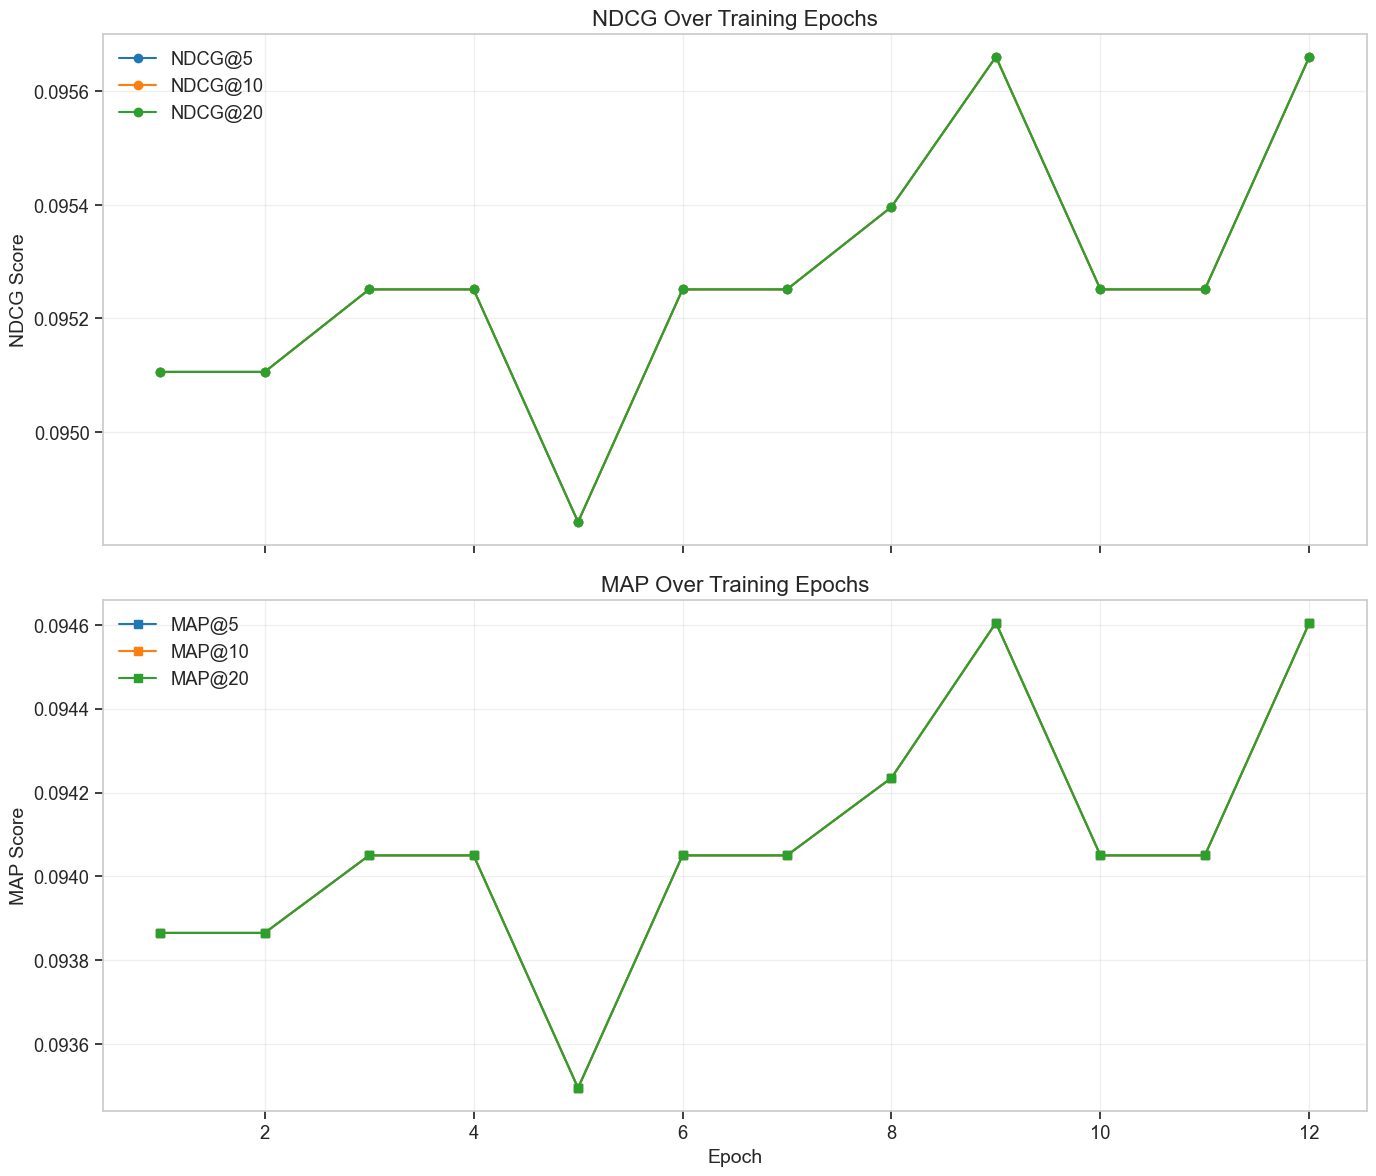

In [7]:
# Cell 7: Recommendation Quality Metrics Visualization
def plot_recommendation_metrics():
    """Visualize recommendation system-specific metrics (NDCG, MAP)"""
    # Setup figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 15))
    
    # Gather data
    ndcg_columns = [col for col in train_history.columns if 'ndcg' in col]
    map_columns = [col for col in train_history.columns if 'map' in col]
    
    print(f"NDCG Columns: {ndcg_columns}")
    print(f"MAP Columns: {map_columns}")
    
    # Get cutoffs (e.g., 5, 10, 20 from ndcg@5, ndcg@10, etc.)
    cutoffs = [int(col.split('@')[1]) for col in ndcg_columns]
    
    print(f"Cutoffs: {cutoffs}")
    
    # Get final validation scores
    final_epoch = train_history.iloc[-1]
    final_ndcg_values = [final_epoch[col] for col in ndcg_columns]
    final_map_values = [final_epoch[col] for col in map_columns]
    
    print(f"Final NDCG Values: {final_ndcg_values}")
    print(f"Final MAP Values: {final_map_values}")
    

    # Get test scores
    test_ndcg_values = [test_results[col.split("_")[1]].iloc[0] for col in ndcg_columns]
    test_map_values = [test_results[col.split("_")[1]].iloc[0] for col in map_columns]
    
    print(f"Test NDCG Values: {test_ndcg_values}")
    print(f"Test MAP Values: {test_map_values}")
    
    # Plot NDCG
    bar_width = 0.35
    x = np.arange(len(cutoffs))
    ax1.bar(x - bar_width/2, final_ndcg_values, bar_width, label='Validation', color=colors['val'])
    ax1.bar(x + bar_width/2, test_ndcg_values, bar_width, label='Test', color=colors['test'])
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'@{cutoff}' for cutoff in cutoffs])
    ax1.set_title('NDCG at Different Cutoffs', fontsize=16)
    ax1.set_ylabel('NDCG Score', fontsize=14)
    ax1.set_xlabel('Cutoff', fontsize=14)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Plot MAP
    ax2.bar(x - bar_width/2, final_map_values, bar_width, label='Validation', color=colors['val'])
    ax2.bar(x + bar_width/2, test_map_values, bar_width, label='Test', color=colors['test'])
    ax2.set_xticks(x)
    ax2.set_xticklabels([f'@{cutoff}' for cutoff in cutoffs])
    ax2.set_title('MAP at Different Cutoffs', fontsize=16)
    ax2.set_ylabel('MAP Score', fontsize=14)
    ax2.set_xlabel('Cutoff', fontsize=14)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    # Add text explaining the metrics
    explanation = """
    NDCG (Normalized Discounted Cumulative Gain): Measures the quality of ranking, 
    considering both relevance and position of items in a ranked list.
    
    MAP (Mean Average Precision): Evaluates the quality of ranked recommendations 
    by considering the precision at each relevant item in the list.
    
    Higher values indicate better recommendation quality for both metrics.
    """
    fig.text(0.5, 0.01, explanation, ha='center', va='bottom', fontsize=12, 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='lightgray', boxstyle='round,pad=0.5'))
    
    plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to make room for text
    plt.show()

    # Plot NDCG and MAP over epochs
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
    
    # Plot NDCG over epochs
    for col in ndcg_columns:
        cutoff = col.split('@')[1]
        ax1.plot(train_history['epoch'], train_history[col], 
                 marker='o', linestyle='-', label=f'NDCG@{cutoff}')
    
    ax1.set_title('NDCG Over Training Epochs', fontsize=16)
    ax1.set_ylabel('NDCG Score', fontsize=14)
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Plot MAP over epochs
    for col in map_columns:
        cutoff = col.split('@')[1]
        ax2.plot(train_history['epoch'], train_history[col], 
                 marker='s', linestyle='-', label=f'MAP@{cutoff}')
    
    ax2.set_title('MAP Over Training Epochs', fontsize=16)
    ax2.set_ylabel('MAP Score', fontsize=14)
    ax2.set_xlabel('Epoch', fontsize=14)
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)
    
    # Set x-axis ticks to be integers
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.tight_layout()
    plt.show()

# Execute the recommendation metrics visualization
plot_recommendation_metrics()

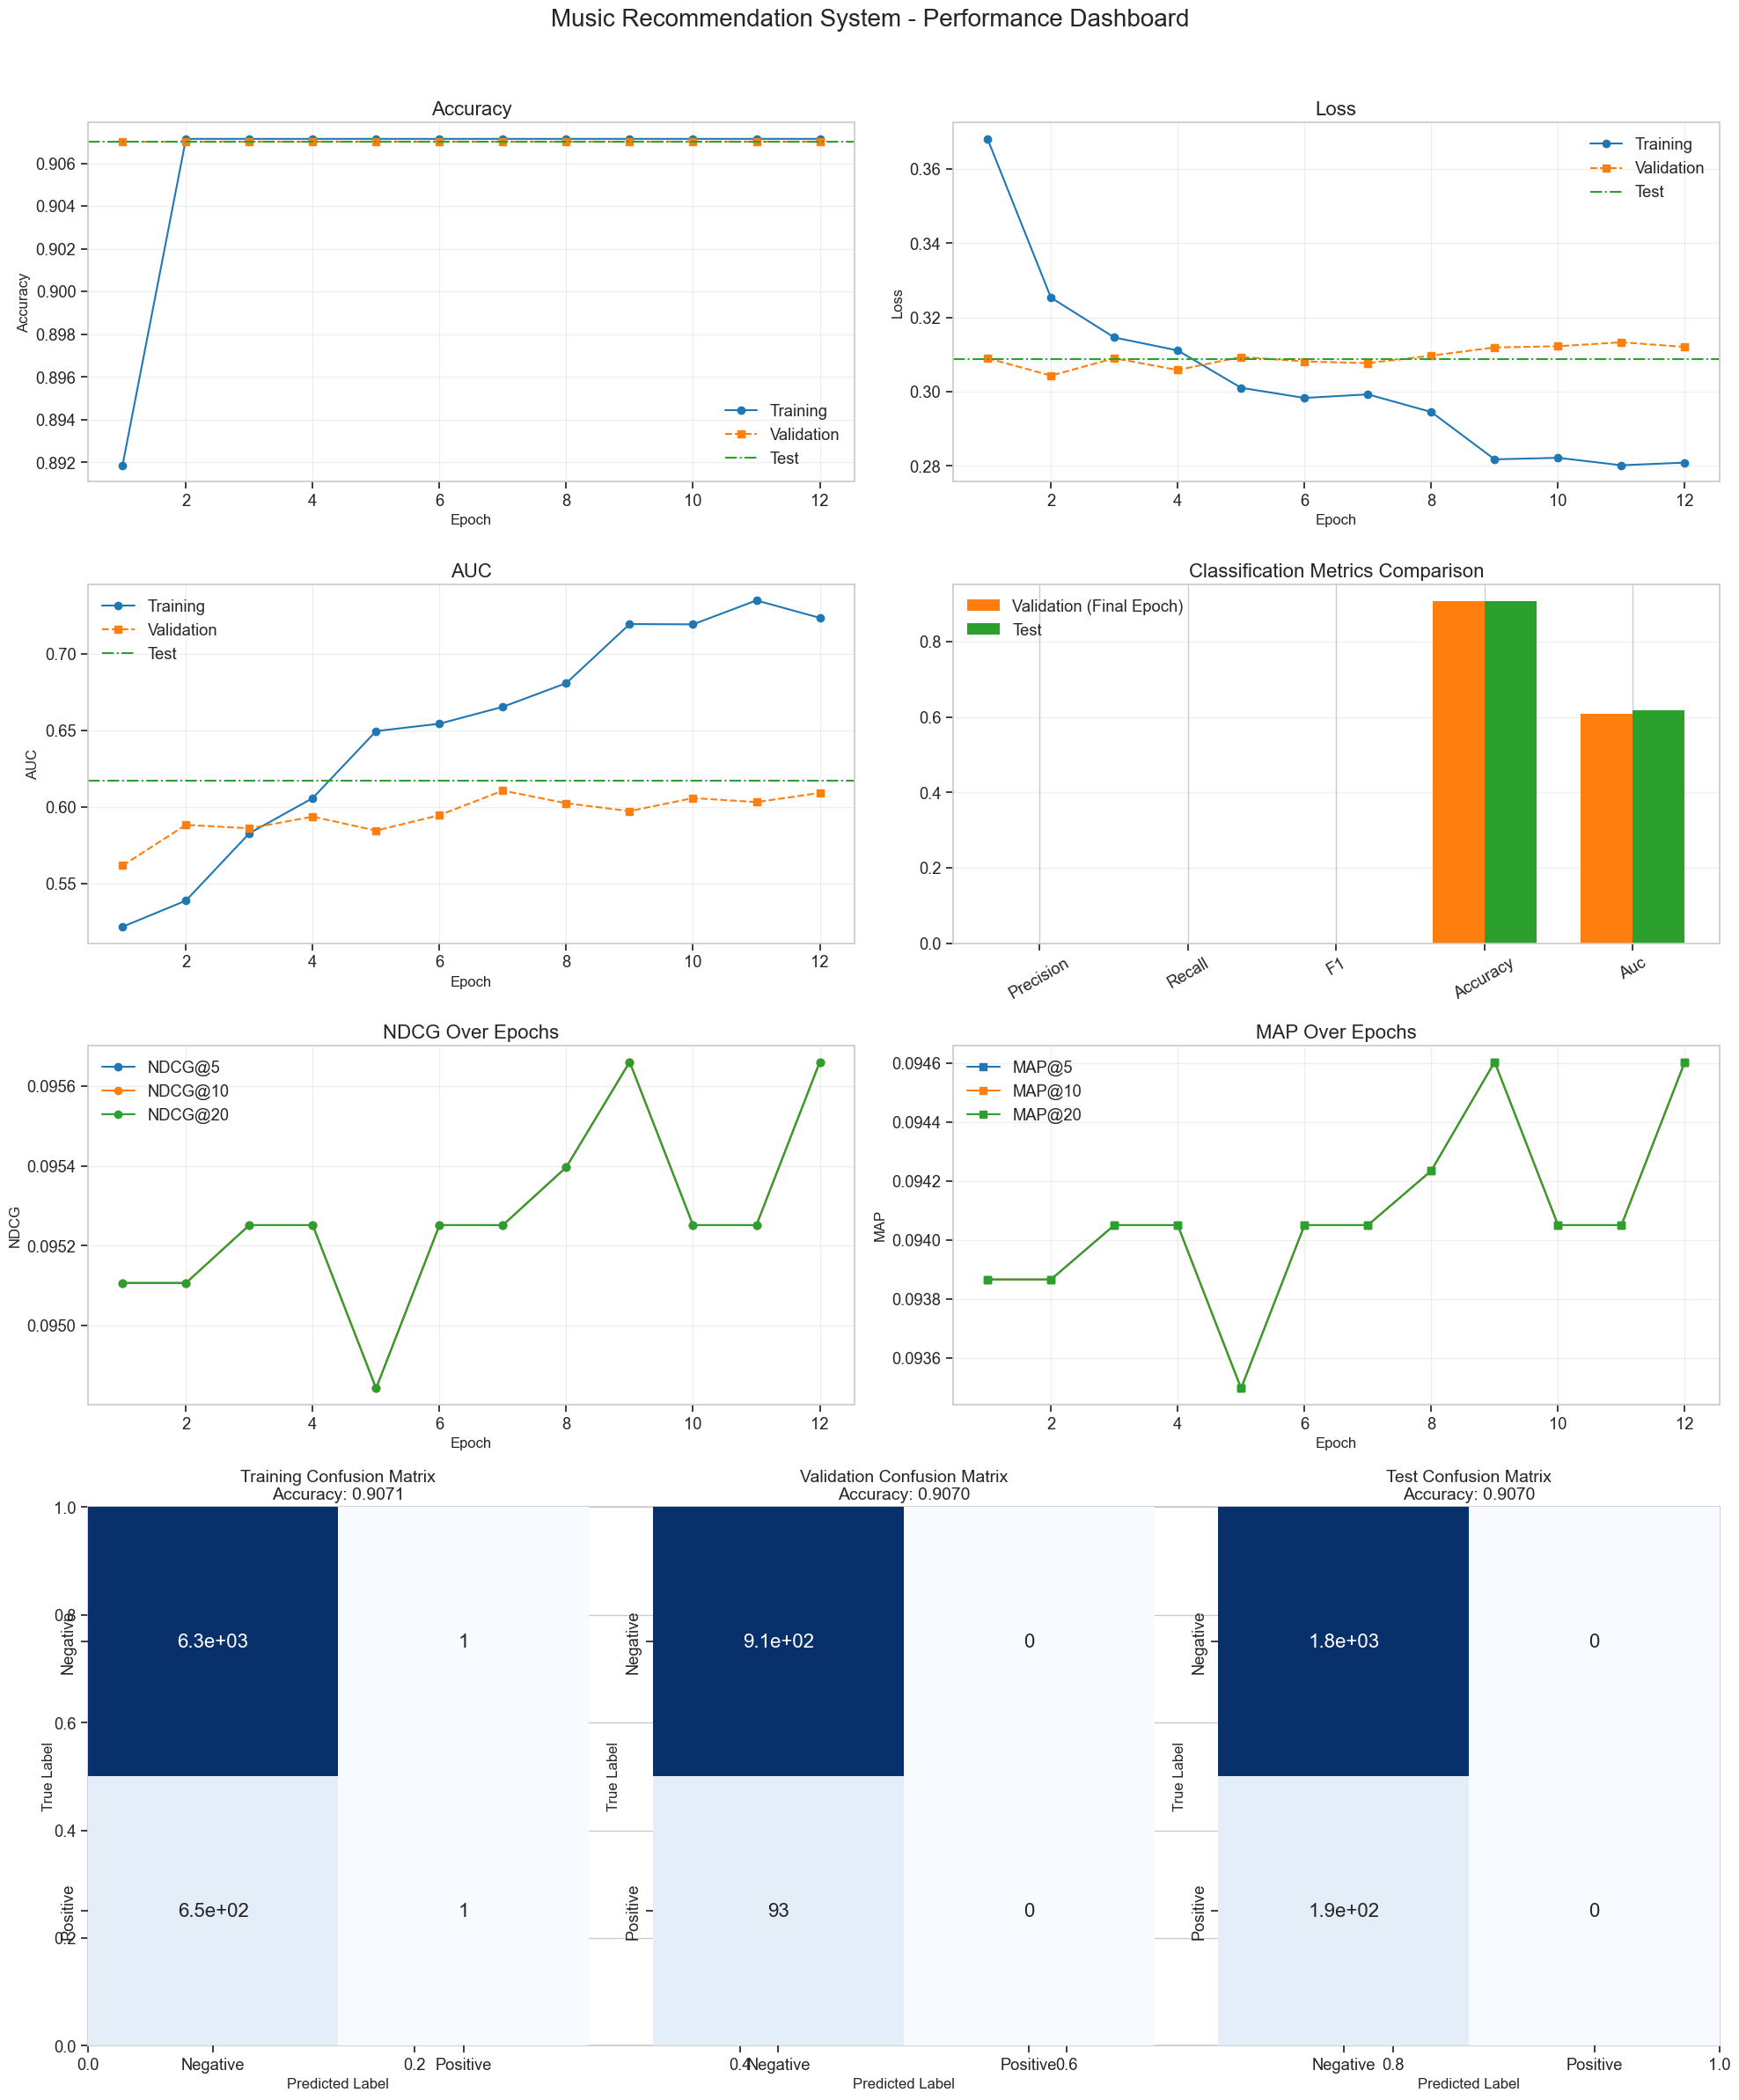

In [8]:
# Cell 8: Comprehensive Dashboard Visualization
def create_comprehensive_dashboard():
    """Create a comprehensive dashboard of all key metrics"""
    # Create a complex figure with GridSpec
    fig = plt.figure(figsize=(20, 24))
    gs = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 1.5])
    
    # 1. Accuracy and Loss Plot (Top Row)
    ax_acc = fig.add_subplot(gs[0, 0])
    ax_loss = fig.add_subplot(gs[0, 1])
    
    # Plot accuracy
    ax_acc.plot(train_history['epoch'], train_history['train_accuracy'], 
               color=colors['train'], marker='o', linestyle='-', label='Training')
    ax_acc.plot(train_history['epoch'], train_history['val_accuracy'], 
               color=colors['val'], marker='s', linestyle='--', label='Validation')
    ax_acc.axhline(y=test_results['accuracy'].iloc[0], color=colors['test'], 
                  linestyle='-.', label='Test')
    
    ax_acc.set_title('Accuracy', fontsize=16)
    ax_acc.set_xlabel('Epoch', fontsize=12)
    ax_acc.set_ylabel('Accuracy', fontsize=12)
    ax_acc.legend(loc='best')
    ax_acc.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax_acc.grid(True, alpha=0.3)
    
    # Plot loss
    ax_loss.plot(train_history['epoch'], train_history['train_loss'], 
                color=colors['train'], marker='o', linestyle='-', label='Training')
    ax_loss.plot(train_history['epoch'], train_history['val_loss'], 
                color=colors['val'], marker='s', linestyle='--', label='Validation')
    ax_loss.axhline(y=test_results['loss'].iloc[0], color=colors['test'], 
                   linestyle='-.', label='Test')
    
    ax_loss.set_title('Loss', fontsize=16)
    ax_loss.set_xlabel('Epoch', fontsize=12)
    ax_loss.set_ylabel('Loss', fontsize=12)
    ax_loss.legend(loc='best')
    ax_loss.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax_loss.grid(True, alpha=0.3)
    
    # 2. AUC and Metrics Plot (Second Row)
    ax_auc = fig.add_subplot(gs[1, 0])
    ax_metrics = fig.add_subplot(gs[1, 1])
    
    # Plot AUC
    ax_auc.plot(train_history['epoch'], train_history['train_auc'], 
               color=colors['train'], marker='o', linestyle='-', label='Training')
    ax_auc.plot(train_history['epoch'], train_history['val_auc'], 
               color=colors['val'], marker='s', linestyle='--', label='Validation')
    ax_auc.axhline(y=test_results['auc'].iloc[0], color=colors['test'], 
                  linestyle='-.', label='Test')
    
    ax_auc.set_title('AUC', fontsize=16)
    ax_auc.set_xlabel('Epoch', fontsize=12)
    ax_auc.set_ylabel('AUC', fontsize=12)
    ax_auc.legend(loc='best')
    ax_auc.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax_auc.grid(True, alpha=0.3)
    
    # Bar chart of final metrics
    metrics = ['precision', 'recall', 'f1', 'accuracy', 'auc']
    final_val_values = [train_history.iloc[-1][f'val_{m}'] for m in metrics]
    test_values = [test_results[m].iloc[0] for m in metrics]
    
    x = np.arange(len(metrics))
    bar_width = 0.35
    
    ax_metrics.bar(x - bar_width/2, final_val_values, bar_width, 
                  color=colors['val'], label='Validation (Final Epoch)')
    ax_metrics.bar(x + bar_width/2, test_values, bar_width, 
                  color=colors['test'], label='Test')
    
    ax_metrics.set_title('Classification Metrics Comparison', fontsize=16)
    ax_metrics.set_xticks(x)
    ax_metrics.set_xticklabels([m.capitalize() for m in metrics], rotation=30)
    ax_metrics.legend(loc='best')
    ax_metrics.grid(axis='y', alpha=0.3)
    
    # 3. Recommendation Metrics (Third Row)
    ax_ndcg = fig.add_subplot(gs[2, 0])
    ax_map = fig.add_subplot(gs[2, 1])
    
    # Get cutoffs
    ndcg_columns = [col for col in train_history.columns if 'ndcg' in col]
    map_columns = [col for col in train_history.columns if 'map' in col]
    cutoffs = [int(col.split('@')[1]) for col in ndcg_columns]
    
    # Plot NDCG over epochs for different cutoffs
    for col in ndcg_columns:
        cutoff = col.split('@')[1]
        ax_ndcg.plot(train_history['epoch'], train_history[col], 
                    marker='o', linestyle='-', label=f'NDCG@{cutoff}')
    
    ax_ndcg.set_title('NDCG Over Epochs', fontsize=16)
    ax_ndcg.set_xlabel('Epoch', fontsize=12)
    ax_ndcg.set_ylabel('NDCG', fontsize=12)
    ax_ndcg.legend(loc='best')
    ax_ndcg.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax_ndcg.grid(True, alpha=0.3)
    
    # Plot MAP over epochs for different cutoffs
    for col in map_columns:
        cutoff = col.split('@')[1]
        ax_map.plot(train_history['epoch'], train_history[col], 
                   marker='s', linestyle='-', label=f'MAP@{cutoff}')
    
    ax_map.set_title('MAP Over Epochs', fontsize=16)
    ax_map.set_xlabel('Epoch', fontsize=12)
    ax_map.set_ylabel('MAP', fontsize=12)
    ax_map.legend(loc='best')
    ax_map.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax_map.grid(True, alpha=0.3)
    
    # 4. Confusion Matrices (Bottom Row, Full Width)
    ax_cm = fig.add_subplot(gs[3, :])
    
    # Get confusion matrix values
    final_epoch = train_history.iloc[-1]
    
    # Create a 1x3 subplot grid within the main subplot
    gs_cm = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[3, :])
    
    ax_cm_train = fig.add_subplot(gs_cm[0, 0])
    ax_cm_val = fig.add_subplot(gs_cm[0, 1])
    ax_cm_test = fig.add_subplot(gs_cm[0, 2])
    
    # Training confusion matrix
    cm_train = np.array([[final_epoch['train_tn'], final_epoch['train_fp']],
                         [final_epoch['train_fn'], final_epoch['train_tp']]])
    
    # Validation confusion matrix
    cm_val = np.array([[final_epoch['val_tn'], final_epoch['val_fp']],
                       [final_epoch['val_fn'], final_epoch['val_tp']]])
    
    # Test confusion matrix
    cm_test = np.array([[test_results['tn'].iloc[0], test_results['fp'].iloc[0]],
                        [test_results['fn'].iloc[0], test_results['tp'].iloc[0]]])
    
    titles = ['Training Confusion Matrix', 'Validation Confusion Matrix', 'Test Confusion Matrix']
    cms = [cm_train, cm_val, cm_test]
    axes = [ax_cm_train, ax_cm_val, ax_cm_test]
    
    for i, (title, cm, ax) in enumerate(zip(titles, cms, axes)):
        # Calculate metrics explicitly from confusion matrix
        tn, fp, fn, tp = cm.ravel()
        total = tn + fp + fn + tp
        if total > 0:
            accuracy = (tn + tp) / total
        else:
            accuracy = 0
            
        # Create heatmap
        sns.heatmap(cm, annot=True, cmap="Blues", ax=ax,
                   cbar=False, annot_kws={"size": 16})
        
        ax.set_title(f"{title}\nAccuracy: {accuracy:.4f}", fontsize=14)
        ax.set_xlabel('Predicted Label', fontsize=12)
        ax.set_ylabel('True Label', fontsize=12)
        ax.set_xticklabels(['Negative', 'Positive'])
        ax.set_yticklabels(['Negative', 'Positive'])
    
    # Set title for the whole figure
    fig.suptitle('Music Recommendation System - Performance Dashboard', fontsize=20, y=0.995)
    
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# Execute the comprehensive dashboard visualization
create_comprehensive_dashboard()

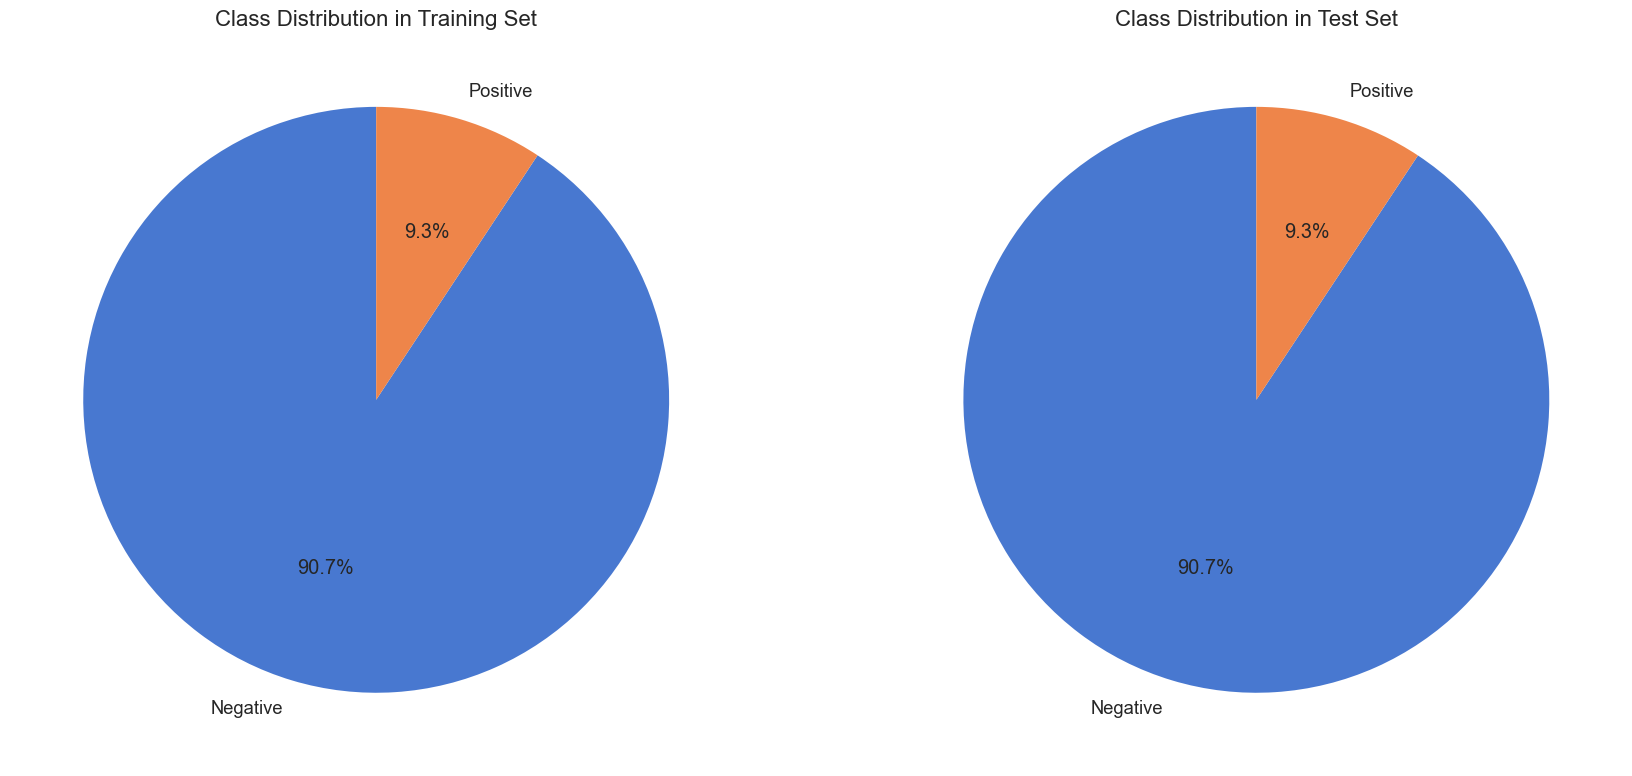

In [9]:
def analyze_class_distribution_and_metrics():
    """Analyze class distribution and provide insights on model performance"""
    
    # Set up figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Class distribution in training set (final epoch)
    final_epoch = train_history.iloc[-1]
    train_classes = [final_epoch['train_tn'] + final_epoch['train_fp'], 
                     final_epoch['train_fn'] + final_epoch['train_tp']]
    
    # Class distribution in test set
    test_classes = [test_results['tn'].iloc[0] + test_results['fp'].iloc[0], 
                    test_results['fn'].iloc[0] + test_results['tp'].iloc[0]]
    
    # Labels and colors
    labels = ['Negative', 'Positive']
    class_colors = ['#4878d0', '#ee854a']
    
    # Plot training pie chart
    ax1.pie(train_classes, labels=labels, autopct='%1.1f%%', startangle=90, colors=class_colors)
    ax1.set_title('Class Distribution in Training Set', fontsize=16)
    
    # Plot test pie chart
    ax2.pie(test_classes, labels=labels, autopct='%1.1f%%', startangle=90, colors=class_colors)
    ax2.set_title('Class Distribution in Test Set', fontsize=16)
    
    plt.tight_layout()
    plt.show()
    
analyze_class_distribution_and_metrics()